In [152]:
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern'] 

In [1]:
import numpy as np

L = 40 # Spatial domain Size
N = 10000 # Spatial points
dx = L / N  # Spatial step
xi = np.linspace(-L / 2, L / 2, N)  # Spatial grid

dt = 0.0001  # Temporal step
t_max = 10 # final evolution time
t_start = 0 # initial measurement time
t_final = t_max # final measurement time
t_steps = int((t_max) / dt) # number of time steps


# Gaussian wave packet parameters
xi0 = 0 # Wave packet initial position
kappa_0 = 20 # Initial momentum
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi) # Initial wave function

# Potential energy (for completeness, unused in this example)
v = np.zeros(N)


# Position measurement range
x_min = -5
x_max = 5



---------------------------------------------


We will perform N measurements, each modeled as the result of the projector: $$\Pi = \int_{\xi_{\text{min}}}^{\xi_{\text{max}}} |\xi\rangle \langle \xi| \, d\xi$$

In [154]:
def perform_position_measurement (psi, xi, x_min, x_max):
    
    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Create a new wavefunction that is zero outside the measurement range
    psi_measured = np.zeros_like(psi)
    psi_measured[measurement_indices] = psi[measurement_indices]

    return psi_measured

In [ ]:
from scipy.integrate import trapezoid
def calculate_position_probability(psi, xi, x_min, x_max):
    
    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Calculate the probability by integrating the probability density over the measurement range
    probability = trapezoid(np.abs(psi[measurement_indices])**2, xi[measurement_indices])

    return probability

---------------------------------------------

##### Crank-Nicolson Scheme Matrices (for nonzero $v(\xi)$)
$$
\begin{array}{cc}
\hat{A} = 
\begin{pmatrix}
1 + \alpha + \beta v(\xi) & -\alpha/2 & 0 & 0 & \cdots \\
-\alpha/2 & 1 + \alpha + \beta v(\xi) & -\alpha/2 & 0 & \cdots \\
0 & -\alpha/2 & 1 + \alpha + \beta v(\xi) & -\alpha/2 & \cdots \\
0 & 0 & -\alpha/2 & 1 + \alpha + \beta v(\xi) & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
&
\alpha = \dfrac{i\Delta\tau}{\kappa_0\left(\Delta\xi\right)^2} \\[40pt]
\hat{B} = 
\begin{pmatrix}
1 - \alpha - \beta v(\xi) & \alpha/2 & 0 & 0 & \cdots \\
\alpha/2 & 1 - \alpha - \beta v(\xi) & \alpha/2 & 0 & \cdots \\
0 & \alpha/2 & 1 - \alpha - \beta v(\xi) & \alpha/2 & \cdots \\
0 & 0 & \alpha/2 & 1 - \alpha - \beta v(\xi) & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
&
\beta = \dfrac{i\Delta\tau\kappa_0}{2}
\end{array}
$$

In [156]:
from scipy.sparse import diags

alpha = 1j * dt / (kappa_0 * dx**2)  
beta = 1j * dt * kappa_0 / 2  

diagonal_a = (1 + alpha + beta * v) * np.ones(N)
off_diagonal = -(alpha / 2) * np.ones(N - 1)
A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

diagonal_b = (1 - alpha - beta * v) * np.ones(N)
B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")


---------------------------------------------

In [157]:
# fourier transform of the wave function, psi in momentum space
def psi_mom(psi):
    psi_k = np.fft.fft(psi) * dx
    return psi_k

------------------------------------------

Processing frame 0/174, time: 0.000

Processing frame 174/174, time: 9.935

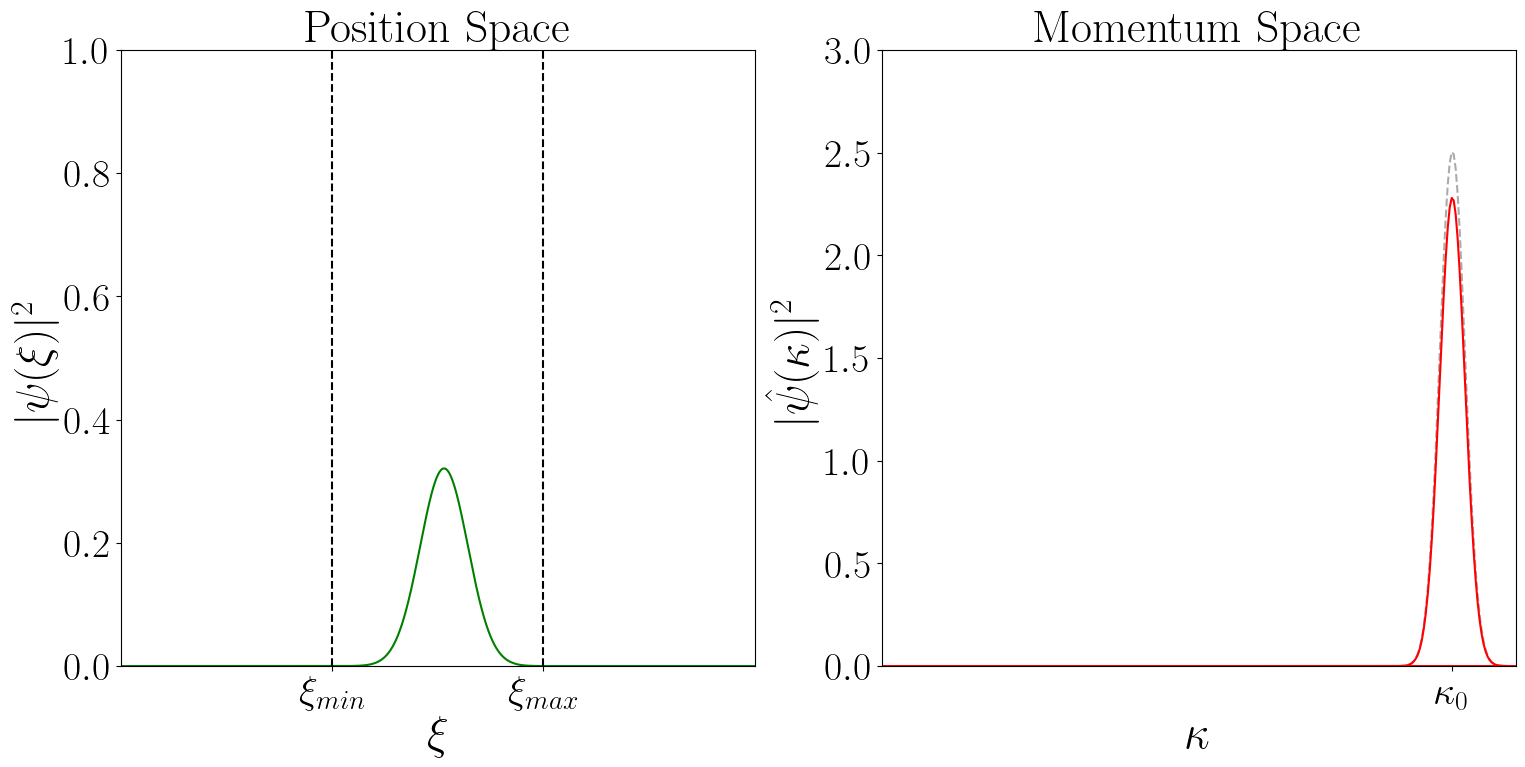

In [ ]:
from matplotlib.animation import FuncAnimation
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
import sys

# Pre-allocate arrays for better performance
num_frames = 175
steps_per_frame = t_steps // num_frames
total_steps = num_frames * steps_per_frame
num_measurements = 100000

times = np.zeros(num_frames)

# Initial conditions
psi = psi0.copy()
k = np.fft.fftfreq(N, d=dx)*2*np.pi
psi_k = psi_mom(psi)  # Initial momentum space wavefunction

# Setup measurement times
if num_measurements == 1:
    momentos_de_medicion = np.array([t_max])
else:
    momentos_de_medicion = np.linspace(t_max / num_measurements + t_start, t_final, num=num_measurements)

# Initialize tracking variables
measurement_index = 0
p = 1
q = 1
last_printed_time = 0

# Create figure and axes
fig, (ax_pos, ax_mom) = plt.subplots(1, 2, figsize=(18, 8))

# Position space plot setup
line_pos, = ax_pos.plot(xi, np.abs(psi)**2, color='green')
ax_pos.set_ylim(0, 1)
ax_pos.set_xlim(-15, 15)
ax_pos.set_ylabel(r"$|\psi(\xi)|^2$", fontsize=33)
ax_pos.tick_params(axis='both', labelsize=28.5)
ax_pos.axvline(x=x_max, color='k', linestyle='--', alpha=1)
ax_pos.axvline(x=x_min, color='k', linestyle='--', alpha=1)
ax_pos.set_xlabel(r"$\xi$", fontsize=33)
ax_pos.set_xticks([-5, 5], [r"$\xi_{min}$", r"$\xi_{max}$"])
ax_pos.set_title(r'Position Space', fontsize=33)

# Momentum space plot setup
ax_mom.plot(k, np.abs(psi_k)**2, color='k', linestyle='--', alpha=0.33)
line_mom, = ax_mom.plot(k, np.abs(psi_k)**2, color='red')
ax_mom.set_ylim(0, 3)
ax_mom.set_xlim(-kappa_0 - 5, kappa_0 + 5)
ax_mom.set_ylabel(r"$|\hat{\psi}(\kappa)|^2$", fontsize=33)
ax_mom.tick_params(axis='both', labelsize=28.5)
ax_mom.set_xlabel(r"$\kappa$", fontsize=33)
ax_mom.set_xticks([kappa_0], [r"$\kappa_0$"])
ax_mom.set_title(r'Momentum Space', fontsize=33)


def update(frame):
    global psi, measurement_index, p, q, last_printed_time
    
    current_time = frame * steps_per_frame * dt
    times[frame] = current_time
    
    # Print current progress (overwrites the same line)
    sys.stdout.write(f"\rProcessing frame {frame}/{num_frames-1}, time: {current_time:.3f}")
    sys.stdout.flush()
    
    # Simulation steps
    for _ in range(steps_per_frame):
        # Solve the Crank-Nicolson step
        psi = spsolve(A, B @ psi)
        current_time += dt
        
        # Only update time display occasionally (not every step)
        if current_time - last_printed_time > 0.5:  # Update display every 0.5 time units
            sys.stdout.write(f"\rProcessing frame {frame}/{num_frames-1}, time: {current_time:.3f}")
            sys.stdout.flush()
            last_printed_time = current_time

        # Check if measurement is needed
        if (measurement_index < len(momentos_de_medicion) and 
            current_time >= momentos_de_medicion[measurement_index]):
            # Perform measurement
            position_prob = calculate_position_probability(psi, xi, x_min, x_max)
            p *= position_prob
            q = p
            p = 1  # Reset probability
            psi = perform_position_measurement(psi, xi, x_min, x_max)
            measurement_index += 1

    # Update visualizations
    line_pos.set_ydata(np.abs(psi)**2)
    
    # Calculate momentum space wavefunction
    psi_k = psi_mom(psi)  
    line_mom.set_ydata(np.abs(psi_k)**2)
    
    return line_pos, line_mom

# Create and save the animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True)
ani.save('position_zeno.mp4', writer='ffmpeg', fps=30, dpi=150)